## Covid-19 Outbreak Analysis Italy
 

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
%matplotlib inline
register_matplotlib_converters()

now = datetime.now()
print("Updated at (UTC TIME):", now)

Updated at (UTC TIME): 2020-03-25 18:33:42.740183


## National Data
## Data of italian provinces
The data is fetched from the repository of the italian government, which is updated daily. First parse the date column:

In [2]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
df = pd.read_csv(url, error_bad_lines=False)
df['date'] = pd.to_datetime(df['data'])

## Plot Trendlines using National Data
To get an overview of how the epidemic is evolving we can plot the trendlines of the different datapoints.

Text(0.5, 1.0, 'Covid-19 trendlines in Italy')

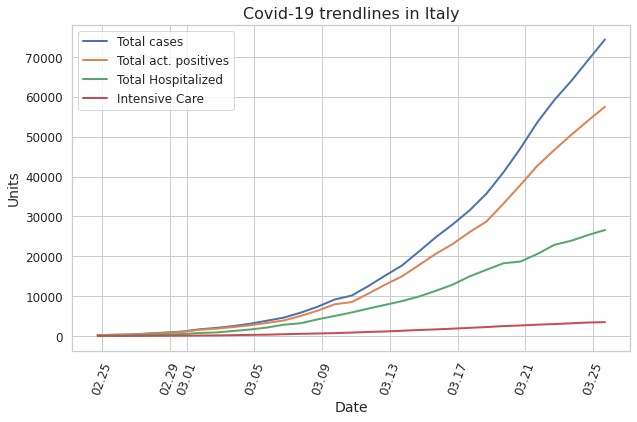

In [3]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='date',y='totale_casi', data=df, label='Total cases', ax=ax, lw=2)
sns.lineplot(x='date',y='totale_attualmente_positivi', data=df, label='Total act. positives', ax=ax, lw=2)
sns.lineplot(x='date',y='totale_ospedalizzati', data=df, label='Total Hospitalized', ax=ax, lw=2)
sns.lineplot(x='date',y='terapia_intensiva', data=df, label='Intensive Care', ax=ax, lw=2)
plt.ylabel('Units', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=70)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.title('Covid-19 trendlines in Italy', fontsize=16)

Text(0.5, 1.0, 'Covid-19 trendlines in Italy')

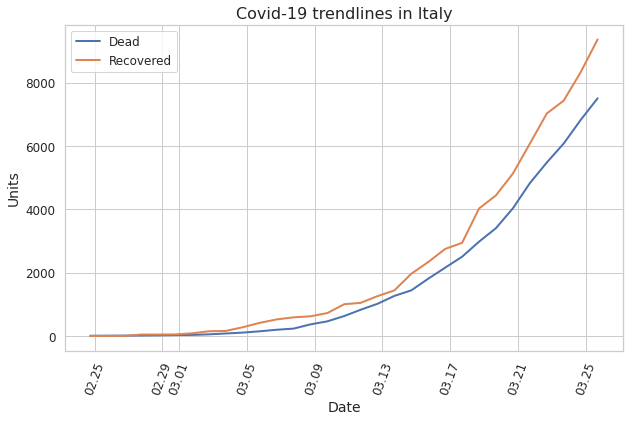

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='date',y='deceduti', data=df, label='Dead', ax=ax, lw=2)
sns.lineplot(x='date',y='dimessi_guariti', data=df, label='Recovered', ax=ax, lw=2)

plt.ylabel('Units', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=70)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.title('Covid-19 trendlines in Italy', fontsize=16)

## Predicting Number of Deaths in Italy
We fit a linear regression model on the log of the death count

In [5]:
import statsmodels.api as sm

df_dead = pd.DataFrame()
days = [i for i in range(df.shape[0])]
df_dead['date'] = df['date']
df_dead['days'] = days
df_dead['deaths'] = df['deceduti']
df_dead['log_deaths'] = np.log(df_dead['deaths'])
df_dead.head()

,date,days,deaths,log_deaths
0,2020-02-24 18:00:00,0,7,1.945910
1,2020-02-25 18:00:00,1,10,2.302585
2,2020-02-26 18:00:00,2,12,2.484907
3,2020-02-27 18:00:00,3,17,2.833213
4,2020-02-28 18:00:00,4,21,3.044522


We will predict 2 days into the future

In [6]:
day_range = range(1, df.shape[0] + 2)


Fit the regression model and predict

In [7]:
X = df_dead.days
X = sm.add_constant(X)
y = df_dead.log_deaths
model = sm.OLS(y,X)
res = model.fit()
a = res.params.const
b = res.params.days
x_pred = [np.exp(a+b*x) for x in day_range]

Here we will do the same thing, but instead of fitting the model on the whole data, we will just use the past 4 days to get a recent trend of how the death count is evolving

In [8]:
df_dead2 = df_dead[df_dead.days > df.shape[0] -5]
X = df_dead2.days
X = sm.add_constant(X)
y = df_dead2.log_deaths
model = sm.OLS(y,X)
res = model.fit()
a = res.params.const
b = res.params.days
x_pred_2 = [np.exp(a+b*x) for x in day_range]

Text(0.5, 1.0, 'Cumulative Deaths in Italy')

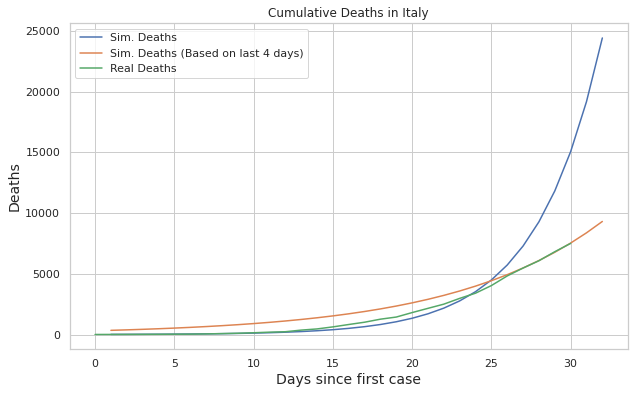

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
plot = sns.lineplot(day_range, x_pred, label="Sim. Deaths")
plot = sns.lineplot(day_range, x_pred_2, label="Sim. Deaths (Based on last 4 days)")
plot = sns.lineplot(days, df_dead['deaths'], label="Real Deaths")

plt.ylabel('Deaths', fontsize=14)
plt.xlabel('Days since first case', fontsize=14)


plot.set_title("Cumulative Deaths in Italy")


## Predicting Number of Cases in Italy
Again we fit a linear regression model on the log of the infected count

In [10]:
import statsmodels.api as sm

df_inf = pd.DataFrame()
days = [i for i in range(df.shape[0])]
df_inf['date'] = df['date']
df_inf['days'] = days
df_inf['infected'] = df['totale_casi']
df_inf['log_infected'] = np.log(df_inf['infected'])
df_inf.head()

,date,days,infected,log_infected
0,2020-02-24 18:00:00,0,229,5.433722
1,2020-02-25 18:00:00,1,322,5.774552
2,2020-02-26 18:00:00,2,400,5.991465
3,2020-02-27 18:00:00,3,650,6.476972
4,2020-02-28 18:00:00,4,888,6.788972


Fit the model to the data 

In [11]:
X = df_inf.days
X = sm.add_constant(X)
y = df_inf.log_infected
model = sm.OLS(y,X)
res = model.fit()
a_exp = res.params.const
b_exp = res.params.days
x_pred_infections = [np.exp(a_exp+ b_exp * x) for x in day_range]

Same thing, but just for the last 4 days to get current trend

In [12]:
df_inf_4days = df_inf[df_inf.days >  df.shape[0] - 5]
X = df_inf_4days.days
X = sm.add_constant(X)
y = df_inf_4days.log_infected
model = sm.OLS(y,X)
res = model.fit()
a = res.params.const
b = res.params.days
x_pred_infections_4days = [np.exp(a+b*x) for x in day_range]

Text(0.5, 1.0, 'Cumulative Infections in Italy')

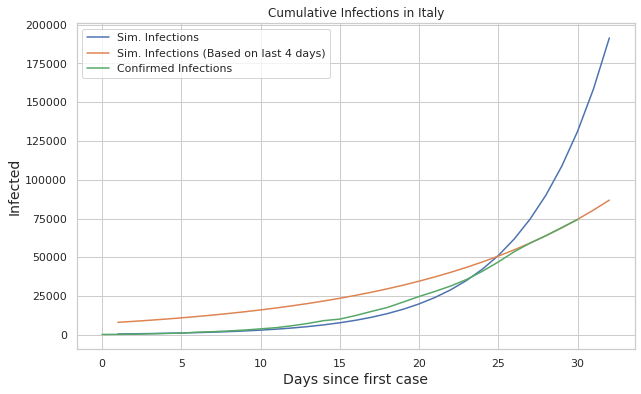

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
plot = sns.lineplot(day_range, x_pred_infections, label="Sim. Infections")
plot = sns.lineplot(day_range, x_pred_infections_4days, label="Sim. Infections (Based on last 4 days)")
plot = sns.lineplot(days, df_inf['infected'], label="Confirmed Infections")


plt.ylabel('Infected', fontsize=14)
plt.xlabel('Days since first case', fontsize=14)


plot.set_title("Cumulative Infections in Italy")


## Plotting the new cases 

In [14]:
df_growth = df.copy()
df_growth['new_cases'] = df_growth['totale_casi'].diff()
df_growth['days'] = range(df_growth.shape[0])

Text(0.5, 1.0, 'New Cases each Day in Italy')

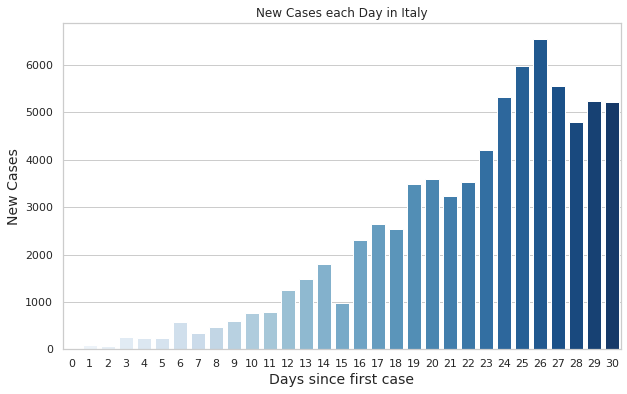

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
plot = sns.barplot(y="new_cases", x="days", data=df_growth, label="New Cases", palette="Blues")

plt.ylabel('New Cases', fontsize=14)
plt.xlabel('Days since first case', fontsize=14)

plot.set_title("New Cases each Day in Italy")

## Fitting a logistic model
In real life we almost never observe an exponential growth, but instead the exponential curve is just the beginning of a logistic curve.

In [16]:
from scipy.optimize import curve_fit, fsolve
import datetime as dt

In [17]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

Text(0.5, 1.0, 'A simple logistic model')

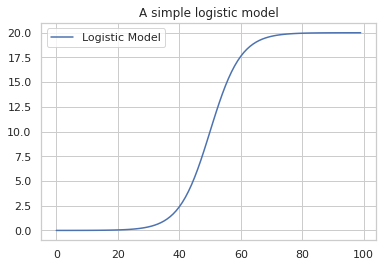

In [18]:
x_pred = [logistic_model(x,5,50,20) for x in range(0,100)]
plot = sns.lineplot(range(0,100), x_pred, label="Logistic Model")
plot.set_title("A simple logistic model")

Preprocessing

In [19]:
df_log = pd.read_csv(url, error_bad_lines=False)
df_log = df_log.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%dT%H:%M:%S'
date = df_log['data']
df_log['day_of_year'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01T00:00:00", FMT)).days )

Fitting the model

In [20]:
x = list(df_log.iloc[:,2])
y = list(df_log.iloc[:,1])
fit = curve_fit(logistic_model, x, y, p0=[2,100,20000],maxfev=2000)

The result gives us three values:

a: the infection speed

b: day of year with maximum new infections

c: total number of recorded infected people at the end of the epidemic

In [21]:
a = fit[0][0]
b = fit[0][1]
c = fit[0][2]
print("a=", a, " b=", b, " c=", c)

a= 5.0934919847859375  b= 80.74677310749274  c= 113884.95192624547


B will be the inflection point, i.e. the point where new infections on a day will be less than on the previous day

In [22]:
date = dt.date(2020,1,1) + dt.timedelta(int(b))
print(date)

2020-03-21


We can compute the end of the epidemic according to the model by solving the equation of the model

In [23]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
date = dt.date(2020,1,1) + dt.timedelta(sol)
print(date)

2020-05-20


### Plotting the logistic curve 

Text(0.5, 1.0, 'Comparison of total infection models')

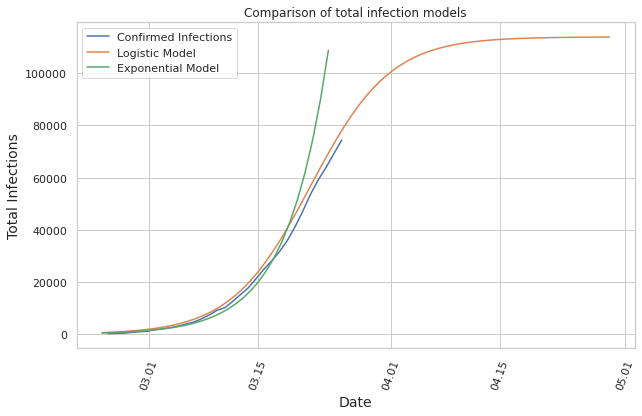

In [24]:
fig, ax = plt.subplots(figsize=(10,6))

# logistic model
x_pred_log = [logistic_model(x,a,b,c) for x in range(54,120)]
y_pred_log = [dt.date(2020,1,1) + dt.timedelta(i) for i in range(54,120)]


# exponential model
x_pred_infections = [np.exp(a_exp + b_exp * x) for x in range(30)]
y_pred_exp = [dt.date(2020,1,1) + dt.timedelta(i) for i in range(54,84)]

plot = sns.lineplot(df_inf['date'], df_inf['infected'], label="Confirmed Infections")
plot = sns.lineplot(y_pred_log, x_pred_log, label="Logistic Model")
plot = sns.lineplot(y_pred_exp, x_pred_infections, label="Exponential Model")

plt.xticks(rotation=70)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))

plt.ylabel('Total Infections', fontsize=14)
plt.xlabel('Date', fontsize=14)

plot.set_title("Comparison of total infection models")


## Learn More

[Data Source](https://github.com/pcm-dpc/COVID-19)

[WHO](https://www.who.int/)

[Ministero della Salute](http://www.salute.gov.it/nuovocoronavirus)
